#### Notes:
- smiley in text could be potentially very predictive. Same as number of !!!, !? ?! and ...
- there are html tags in the text
- there is review text and review summary, both might be useful
- we predict the review score
- we should evaluate correlation between review usefulness and review score, possible feature
- if users review a lot they can be very critical person, user ID can be also an predictive feature
- helpfulness should be kept along with it's numerator and denominator to model scale of rating, in case it is also a feauture (24/24 vs 1/1 might mean something)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

## Read records

In [2]:
DATA='/Users/matejkvassay/data/s.txt'
ENCODING='iso-8859-1'

In [3]:
def parse_line(line):
    splitted_line=line.split(':')
    return {splitted_line[0]:':'.join(splitted_line[1:]).strip()}

def read_dataset(path):
    records=[]
    with open(path, 'rb') as f:
        current_record={}
        first=True
        for x in f.readlines():
            line=x.decode(ENCODING)
            if line.startswith('product/'):
                if not first:
                    records.append(current_record)
                first=False
                current_record=parse_line(line)
                continue
            if line.startswith('review/'):
                current_record.update(parse_line(line))
    return records

In [4]:
%%time
records=read_dataset(DATA)

CPU times: user 8.22 s, sys: 697 ms, total: 8.92 s
Wall time: 8.98 s


In [5]:
records[0]

{'product/productId': 'B001E4KFG0',
 'review/userId': 'A3SGXH7AUHU8GW',
 'review/profileName': 'delmartian',
 'review/helpfulness': '1/1',
 'review/score': '5.0',
 'review/time': '1303862400',
 'review/summary': 'Good Quality Dog Food',
 'review/text': 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'}

## Analyze & normalize data

In [6]:
take_columns=[]

In [7]:
df=pd.DataFrame(records)

### Initial normalization

#### Helpfulness 

In [8]:
def parse_helpfulness(row):
    if row is not np.nan:
        first,second=row.split('/')
        return float(first),float(second)
    else:
        return np.nan,np.nan

In [9]:
df['review/helpfulness']=df['review/helpfulness'].replace('0/0',np.nan)

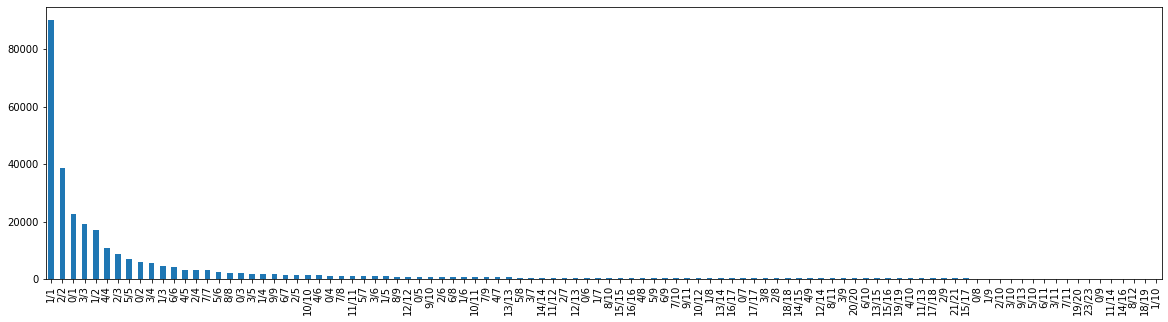

In [10]:
df['review/helpfulness'].value_counts().head(100).plot.bar(figsize=(20,5))

In [11]:
df['help1']=df['review/helpfulness'].apply(parse_helpfulness).apply(lambda x: x[0])
df['help2']=df['review/helpfulness'].apply(parse_helpfulness).apply(lambda x: x[1])
df.loc[df['help1'] > df['help2'], 'help1']=np.nan
df.loc[df['help1']>df['help2'], 'help2']=np.nan
df['help']=df['help1']/df['help2'] # helpfulness ratio

In [12]:
df['help'].describe()

count    298400.000000
mean          0.776965
std           0.346296
min           0.000000
25%           0.600000
50%           1.000000
75%           1.000000
max           1.000000
Name: help, dtype: float64

In [13]:
df['help'].isnull().sum()

270053

In [14]:
def binarize(x):
    if np.isnan(x):
        return np.nan
    return 1.0 if x>=0.7 else 0.0

In [15]:
df['help_bin']=df['help'].apply(binarize)

In [16]:
df['help_bin'].isnull().sum()

270053

- helpfulness is almost binary feature
- values missed in almost 50% of samples
- not clear how rating system works, different rating scales appear
- can be predictive of the sentiment

In [17]:
take_columns+=['help','help1','help2']

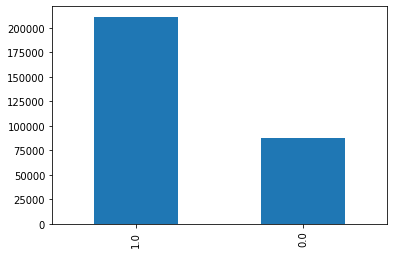

In [38]:
df['help_bin'].value_counts().plot.bar()

#### Review score
(prediction target)

In [18]:
df['review/score'].describe()

count     568453
unique         5
top          5.0
freq      363121
Name: review/score, dtype: object

5.0    363121
4.0     80655
1.0     52268
3.0     42640
2.0     29769
Name: y, dtype: int64


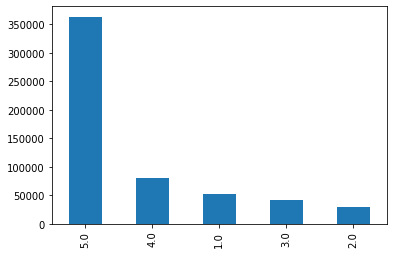

In [19]:
df['y']=df['review/score']
print(df['y'].value_counts())
df['y'].value_counts().plot.bar()

- high label imbalance, most people are positive
- algorithm which assigns 5.0 to all reviews could be a baseline

In [20]:
take_columns+=['y']

#### Correlation between helpfulness and review score

In [42]:
df['help_bin'].corr(df['y'])

TypeError: unsupported operand type(s) for /: 'str' and 'int'